# Importations

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import pandas as pd
from scipy.spatial import ConvexHull, Delaunay
from scipy.cluster.hierarchy import dendrogram, linkage

# Some basic images transformation

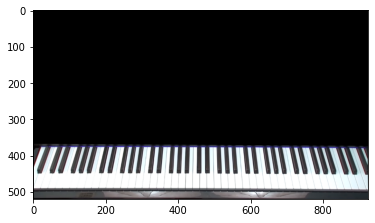

In [2]:
img = cv2.imread('pictures/piano.png')
plt.imshow(img)
plt.show()

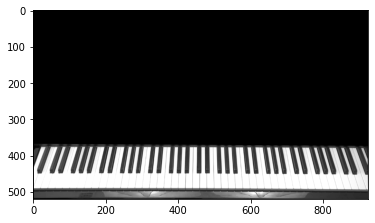

In [3]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
plt.imshow(gray, cmap='gray')
plt.show()

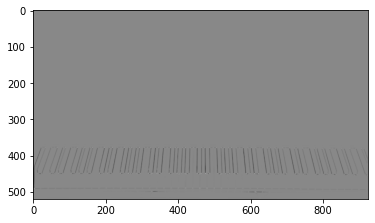

In [4]:
dst = cv2.cornerHarris(gray,2,3,0.04)
plt.imshow(dst, cmap='gray')
plt.show()

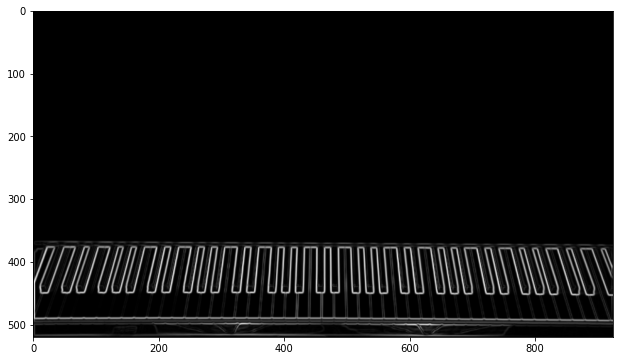

In [5]:
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
sobel = np.sqrt(sobelx**2 + sobely**2)
plt.figure(figsize=(16,6))
plt.imshow(sobel, cmap='gray')
plt.show()

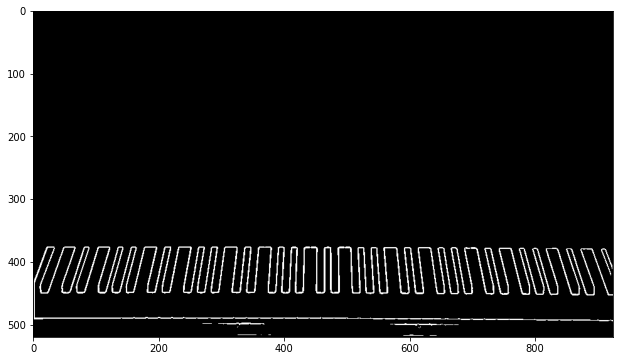

In [6]:
sobel_black_white = sobel.copy()
threshold = 5000
sobel_black_white[sobel_black_white < threshold] = 0
sobel_black_white[sobel_black_white >= threshold] = 1
plt.figure(figsize=(16,6))
plt.imshow(sobel_black_white, cmap='gray')
plt.show()

In [7]:
def sobel_threshold(threshold):
    sobel_black_white = sobel.copy()
    sobel_black_white[sobel_black_white <= threshold] = 0
    sobel_black_white[sobel_black_white > threshold] = 1
    plt.figure(figsize=(16,6))
    plt.imshow(sobel_black_white, cmap='gray')
    plt.show()

interact(sobel_threshold, threshold=widgets.IntSlider(min=0,max=10000,step=100,value=5000))

interactive(children=(IntSlider(value=5000, description='threshold', max=10000, step=100), Output()), _dom_cla…

<function __main__.sobel_threshold(threshold)>

# Video

With Markdown

<video controls src="mp4/canon_in_D.mp4">animation</video>

In [8]:
from IPython.display import Video
Video('mp4/canon_in_D.mp4')

In [9]:
cap = cv2.VideoCapture('mp4/canon_in_D.mp4') # Open the video file for reading

In [10]:
# Some information about the video

fps = cap.get(cv2.CAP_PROP_FPS)
frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
                int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print('Frame rate: ', fps)
print('Frame size: ', frame_size)

Frame rate:  29.967791810918403
Frame size:  (1280, 720)


In [11]:
# Here we use the interact function to create a slider to select the frame number

def select_frame(frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # Set the frame number to read
    ret, frame = cap.read() # ret is a boolean that is True if the frame was read correctly
    if ret == True:
        plt.figure(figsize=(16,6))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
        plt.imshow(frame)
        plt.show()
    else:
        print('Frame not found')

interact(select_frame, frame_number=widgets.IntSlider(min=0,max=cap.get(cv2.CAP_PROP_FRAME_COUNT),step=1,value=0))


interactive(children=(IntSlider(value=0, description='frame_number', max=6046), Output()), _dom_classes=('widg…

<function __main__.select_frame(frame_number)>

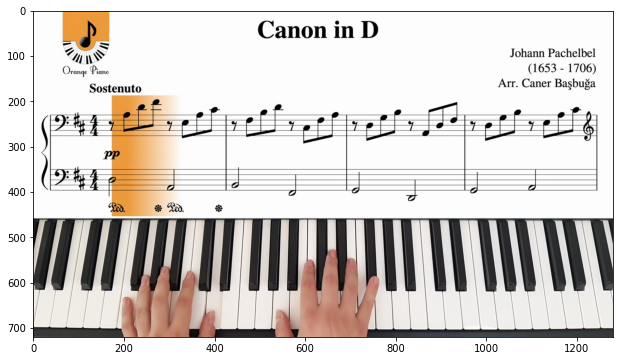

In [12]:
# Get the 100th frame 'img' just to experiment with the code
n = 100
cap.set(cv2.CAP_PROP_POS_FRAMES, n)
ret, frame = cap.read()
plt.figure(figsize=(16,6))
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

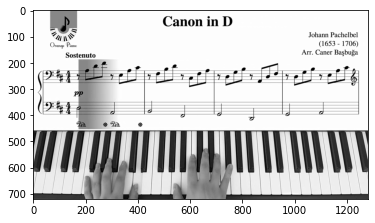

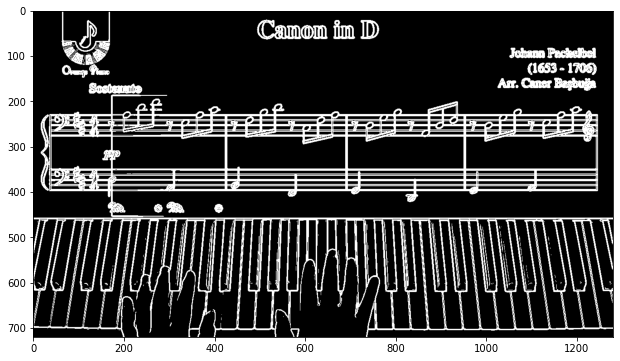

In [13]:
# The goal is to crop the image to the piano keys
# We will use the sobel filter to find the edges of the keys
# We will then use the hough transform to find the lines that represent the keys

# Step 1: Convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
plt.imshow(gray, cmap='gray')
plt.show()

# Step 2: Apply the sobel filter
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
sobel = np.sqrt(sobelx**2 + sobely**2)
sobel = (sobel/sobel.max()*255).astype(np.uint8) # For display purposes and Hough transform
black_white_threshold = 30
sobel[sobel <= black_white_threshold] = 0
sobel[sobel > black_white_threshold] = 255
plt.figure(figsize=(16,6))
plt.imshow(sobel, cmap='gray')
plt.show()


Number of lines found:  11224


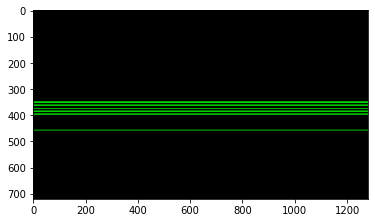

In [14]:
# Step 3: Find the line that separates the piano from the background
# The task is easy here because there is an almost horizontal line that separates the piano from the background
# From the left side of the image to the right side of the image, the line is almost horizontal and continuous
# In order to find the line, we will use the hough transform
# The hough transform will find the lines that are continuous and almost horizontal
# We will then select the line that is closest to the horizontal line

rho_resolution = 1
theta_resolution = np.pi/180
threshold = 155
hough_lines = cv2.HoughLines(image = sobel, rho = rho_resolution, theta = theta_resolution, threshold = threshold)
print('Number of lines found: ', len(hough_lines))

# lines[0][0] is the first line found, of the form [rho, theta] where rho is the distance from the origin and theta is the angle
# The origin is the top left corner of the image
# The lines are represented by the equation r = x*cos(theta) + y*sin(theta)
# Draw the lines
color=[0, 255, 0]
thickness=2
hough_lines_image = np.zeros_like(img)
for i in range(10): #range(len(hough_lines)):
    line = hough_lines[i]
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + cap.get(cv2.CAP_PROP_FRAME_WIDTH)*(-b))
        y1 = int(y0 + cap.get(cv2.CAP_PROP_FRAME_WIDTH)*(a))
        x2 = int(x0 - cap.get(cv2.CAP_PROP_FRAME_WIDTH)*(-b))
        y2 = int(y0 - cap.get(cv2.CAP_PROP_FRAME_WIDTH)*(a))

        cv2.line(hough_lines_image,(x1,y1),(x2,y2),color,thickness)  

plt.imshow(hough_lines_image)
plt.show()

Number of lines found:  119


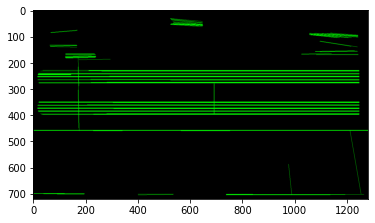

In [15]:
# Now we use cv2.HoughLinesP to find the segments of lines
rho_resolution = 1
theta_resolution = np.pi/180
threshold = 155
hough_lines = cv2.HoughLinesP(image = sobel, rho = rho_resolution, theta = theta_resolution, threshold = threshold,
                            minLineLength = 100, maxLineGap = 10)
print('Number of lines found: ', len(hough_lines))

color=[0, 255, 0]
thickness=1
hough_lines_image = np.zeros_like(img)
for i in range(len(hough_lines)):
    line = hough_lines[i]
    for a,b,c,d in line:
        cv2.line(hough_lines_image,(a,b),(c,d),color,thickness)

plt.imshow(hough_lines_image)
plt.show()

In [16]:
# Now we use sliders for rho, theta, threshold, minLineLength, maxLineGap

def hough_lines_p(rho_resolution, theta_resolution, threshold, minLineLength, maxLineGap):
    rho_resolution = rho_resolution
    theta_resolution = theta_resolution*np.pi/180
    threshold = threshold
    minLineLength = minLineLength
    maxLineGap = maxLineGap
    hough_lines = cv2.HoughLinesP(image = sobel, rho = rho_resolution, theta = theta_resolution, threshold = threshold,
                                minLineLength = minLineLength, maxLineGap = maxLineGap)
    print('Number of lines found: ', len(hough_lines))

    color=[0, 255, 0]
    thickness=10
    hough_lines_image = np.zeros_like(img)
    for i in range(len(hough_lines)):
        line = hough_lines[i]
        for a,b,c,d in line:
            length = np.sqrt((a-c)**2 + (b-d)**2)
            if length > 1270 and abs(b-d) < 10:
                cv2.line(hough_lines_image,(a,b),(c,d),color,thickness)
    original_image_with_hough_lines = cv2.addWeighted(img, 0.8, hough_lines_image, 1, 0)
    plt.imshow(original_image_with_hough_lines)

interact(hough_lines_p, rho_resolution = (1, 1, 1),
            theta_resolution = (1, 1, 1), threshold = (1, 200, 1),
            minLineLength = (1200, 1280, 1), maxLineGap = (1, 40, 1))

# 1,1,100,1240,20 is a good combination


interactive(children=(IntSlider(value=1, description='rho_resolution', max=1, min=1), IntSlider(value=1, descr…

<function __main__.hough_lines_p(rho_resolution, theta_resolution, threshold, minLineLength, maxLineGap)>

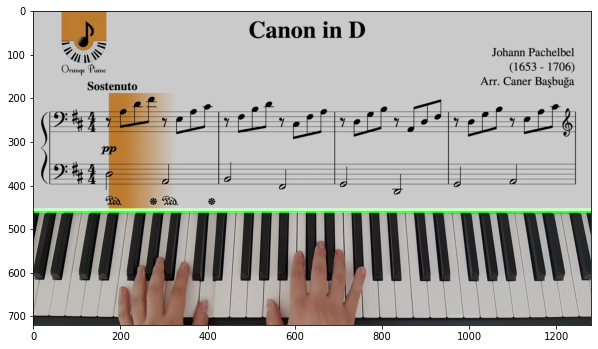

In [17]:
# We clean the code and make a pipeline function 
# that takes an image as input and returns the image with the line that separates the piano from the background

def pipeline(img: np.ndarray) -> np.ndarray: # img is a RGB array
    
    # Step 1: Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Step 2: Apply the sobel filter
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel/sobel.max()*255).astype(np.uint8) # For display purposes and Hough transform
    black_white_threshold = 30
    sobel[sobel <= black_white_threshold] = 0
    sobel[sobel > black_white_threshold] = 255

    # Step 3: Use the hough transform to find the line that separates the piano from the background
    rho_resolution = 1
    theta_resolution = np.pi/180
    threshold = 100
    minLineLength = 1240
    maxLineGap = 10

    hough_lines = cv2.HoughLinesP(image = sobel, rho = rho_resolution, theta = theta_resolution, threshold = threshold,
                                minLineLength = minLineLength, maxLineGap = maxLineGap)

    color=[0, 255, 0]
    thickness=10
    hough_lines_image = np.zeros_like(img)
    for i in range(len(hough_lines)):
        line = hough_lines[i]
        a,b,c,d = line[0]
        length = np.sqrt((a-c)**2 + (b-d)**2)
        if length > 1270 and abs(b-d) < 10: # We want the line to be almost horizontal and long enough
            cv2.line(hough_lines_image,(a,b),(c,d),color,thickness)
            break # We only want one line
    original_image_with_hough_lines = cv2.addWeighted(img, 0.8, hough_lines_image, 1, 0)
    #plt.figure(figsize=(10,10))
    #plt.imshow(original_image_with_hough_lines)
    #plt.show()
    return original_image_with_hough_lines

plt.figure(figsize=(10,10))
plt.imshow(pipeline(img))
plt.show()

In [18]:
# Use the pipeline function on every frame of the video

def select_frame(frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # Set the frame number to read
    ret, frame = cap.read() # ret is a boolean that is True if the frame was read correctly
    if ret == True:
        plt.figure(figsize=(16,6))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
        result = pipeline(frame)
        plt.imshow(result)
        plt.show()
    else:
        print('Frame not found')

interact(select_frame, frame_number=widgets.IntSlider(min=0,max=cap.get(cv2.CAP_PROP_FRAME_COUNT),step=1,value=0))

interactive(children=(IntSlider(value=0, description='frame_number', max=6046), Output()), _dom_classes=('widg…

<function __main__.select_frame(frame_number)>

In [19]:
# Since the camera does not move, we can use the same line for every frame
# We rewrite the pipeline function to return the line instead of the image (a,b,c,d)

def pipeline(img: np.ndarray) -> np.ndarray: # img is a RGB array
    
    # Step 1: Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Step 2: Apply the sobel filter
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel/sobel.max()*255).astype(np.uint8) # For display purposes and Hough transform
    black_white_threshold = 30
    sobel[sobel <= black_white_threshold] = 0
    sobel[sobel > black_white_threshold] = 255

    # Step 3: Use the hough transform to find the line that separates the piano from the background
    rho_resolution = 1
    theta_resolution = np.pi/180
    threshold = 100
    minLineLength = 1240
    maxLineGap = 10

    hough_lines = cv2.HoughLinesP(image = sobel, rho = rho_resolution, theta = theta_resolution, threshold = threshold,
                                minLineLength = minLineLength, maxLineGap = maxLineGap)

    for i in range(len(hough_lines)):
        line = hough_lines[i]
        a,b,c,d = line[0]
        length = np.sqrt((a-c)**2 + (b-d)**2)
        if length > 1270 and abs(b-d) < 10: # We want the line to be almost horizontal and long enough
            return a,b,c,d

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
a,b,c,d = pipeline(frame)
a,b,c,d

(0, 459, 1279, 459)

In [20]:
y = b # y is the y coordinate of the line

# Now we can use the line to separate the piano from the background
# Crop the image to keep only the piano

def select_frame(frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # Set the frame number to read
    ret, frame = cap.read() # ret is a boolean that is True if the frame was read correctly
    if ret == True:
        plt.figure(figsize=(16,6))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
        result = frame[y:,:,:]
        plt.imshow(result)
        plt.show()
    else:
        print('Frame not found')

interact(select_frame, frame_number=widgets.IntSlider(min=0,max=cap.get(cv2.CAP_PROP_FRAME_COUNT),step=1,value=0))

interactive(children=(IntSlider(value=0, description='frame_number', max=6046), Output()), _dom_classes=('widg…

<function __main__.select_frame(frame_number)>

In [21]:
# Crop the video to keep only the piano
# Save the video as a new file

fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('mp4/output_full_code/0_piano.mp4', # or .mkv
    fourcc, cap.get(cv2.CAP_PROP_FPS),
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))-y))

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
while ret:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = frame[y:,:,:]
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame)
    ret, frame = cap.read()

out.release()
cv2.destroyAllWindows() # Close all windows

OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


# Mask

In [22]:
cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')

In [23]:
def show_frame(cap, frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(16,6))
        plt.imshow(frame)
        plt.show()
    else:
        print('Frame not found')

def get_frame(cap, frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return ret, frame
    else:
        return ret, None

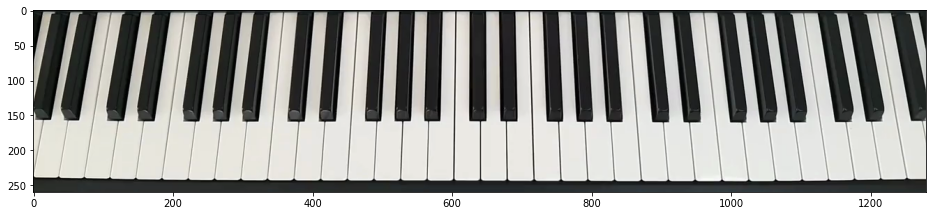

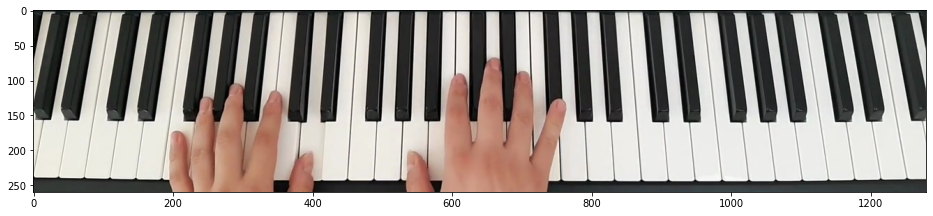

In [24]:
_, frame_mask = get_frame(cap, 0)
_, frame = get_frame(cap, 100)
show_frame(cap, 0)
show_frame(cap, 100)

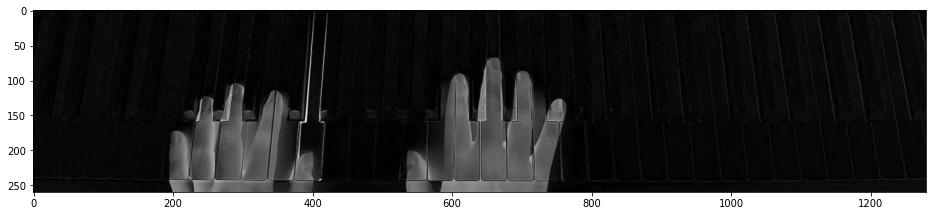

In [25]:
# Isolate the hands by subtracting the mask from the frame
difference = frame.astype(float) - frame_mask.astype(float)
difference = np.abs(difference)
difference = difference.astype(np.uint8)
difference = cv2.cvtColor(difference, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(16,6))
plt.imshow(difference, cmap='gray')
plt.show()

In [26]:
# Do this for all frames and save as a new video
cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')
fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('mp4/output_full_code/1_piano_isolate_hands.mp4', # or .mkv
    fourcc, cap.get(cv2.CAP_PROP_FPS),
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

_, frame_mask = get_frame(cap, 0)
frame_mask = cv2.cvtColor(frame_mask, cv2.COLOR_RGB2GRAY)
cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')

n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

for i in tqdm(range(0, n)):
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    difference = frame.astype(float) - frame_mask.astype(float)
    difference = np.abs(difference)
    difference = difference.astype(np.uint8)
    difference = cv2.cvtColor(difference, cv2.COLOR_GRAY2RGB)
    out.write(difference)

out.release()
cap.release()



OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
100%|██████████| 6014/6014 [00:22<00:00, 266.63it/s]


# Detection of pressed key

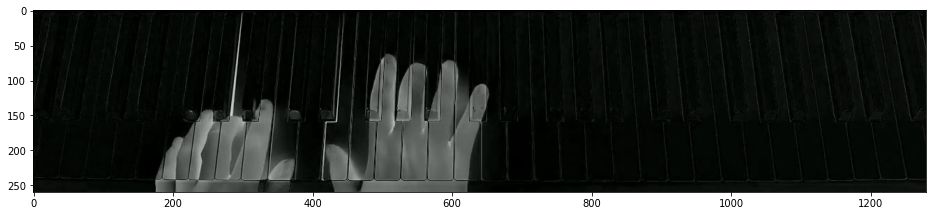

In [27]:
cap = cv2.VideoCapture('mp4/output_full_code/1_piano_isolate_hands.mp4')

_, frame = get_frame(cap, 100)
show_frame(cap, 175)

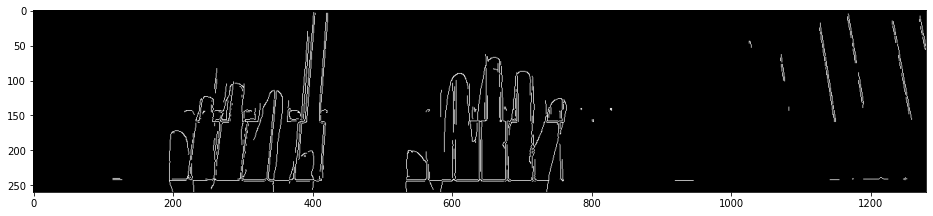

In [28]:
# The goal is to detect the keys that are pressed
# There are many edges, but we have to choose the ones that have a sufficient width

# First, we will try to detect the edges
# We will use the Canny edge detector

edges = cv2.Canny(frame, 100, 200)
plt.figure(figsize=(16,6))
plt.imshow(edges, cmap='gray')
plt.show()

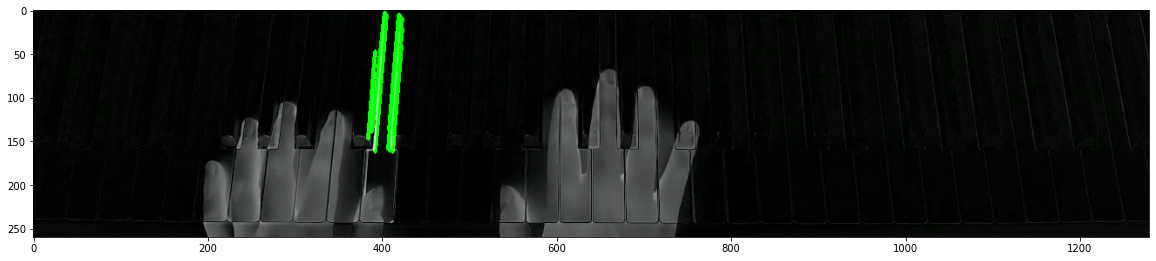

In [29]:
# We can use HoughLines(P) to detect lines
# https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

# We clean the code and make a pipeline function 
# that takes an image as input and returns the image with the line that separates the piano from the background

def pipeline(img, sobel_threshold=30, hough_threshold=100, hough_min_line_length=100, hough_max_line_gap=10):
    
    # Step 1: Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Step 2: Apply the sobel filter
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=9)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=9)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel/sobel.max()*255).astype(np.uint8) # For display purposes and Hough transform
    sobel[sobel <= sobel_threshold] = 0
    sobel[sobel > sobel_threshold] = 255

    #plt.imshow(sobel, cmap='gray')

    # Step 3: Use the hough transform to find the line that separates the piano from the background
    rho_resolution = 1
    theta_resolution = np.pi/180
    threshold = hough_threshold
    minLineLength = hough_min_line_length
    maxLineGap = hough_max_line_gap

    hough_lines = cv2.HoughLinesP(image = sobel, rho = rho_resolution, theta = theta_resolution, threshold = threshold,
                                minLineLength = minLineLength, maxLineGap = maxLineGap)

    color=[0, 255, 0]
    thickness=4
    hough_lines_image = np.zeros_like(img)
    if hough_lines is not None:
        for i in range(len(hough_lines)):
            line = hough_lines[i]
            a,b,c,d = line[0]
            if abs(a-c) < 40 and (b < 70 or d < 70) and (b < 180 and d < 180):
                # piano keys are vertical and must start at the top of the image, and be above hands
                cv2.line(hough_lines_image, (a,b), (c,d), color, thickness)
        original_image_with_hough_lines = cv2.addWeighted(img, 0.8, hough_lines_image, 1, 0)
    else:
        original_image_with_hough_lines = img
    return original_image_with_hough_lines

plt.figure(figsize=(20,10))
plt.imshow(pipeline(frame))
plt.show()

In [30]:
# We can now apply the pipeline to all the frames of the video
# and save the result as a new video
# 2 min

cap = cv2.VideoCapture('mp4/output_full_code/1_piano_isolate_hands.mp4')
fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('mp4/output_full_code/2_piano_key_detector.mp4', # or .mkv
    fourcc, cap.get(cv2.CAP_PROP_FPS),
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm(range(0, n)):
    ret, frame = cap.read()
    if not ret:
        break
    frame = pipeline(frame)
    out.write(frame)

out.release()
cap.release()

OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
100%|██████████| 6014/6014 [01:16<00:00, 79.04it/s]


In [31]:
# use widgets
# first parameter is whether we use canny or sobel
# second parameter is frame number
# third parameter is the threshold for canny or sobel

cap = cv2.VideoCapture('mp4/output_full_code/1_piano_isolate_hands.mp4')

def show_frame_with_pipeline(canny: bool, frame_number: int, threshold1: int, threshold2: int):
    _, frame = get_frame(cap, frame_number)
    if canny:
        edges = cv2.Canny(frame, threshold1, threshold2)
        plt.figure(figsize=(10,10))
        plt.imshow(edges, cmap='gray')
    else:
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
        sobel = np.sqrt(sobelx**2 + sobely**2)
        sobel = (sobel/sobel.max()*255).astype(np.uint8) # For display purposes and Hough transform
        if threshold2 < 100: # just to use as boolean
            sobel[sobel <= threshold1] = 0
            sobel[sobel > threshold1] = 255
        plt.figure(figsize=(10,10))
        plt.imshow(sobel, cmap='gray')
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(frame)
    plt.show()

interact(show_frame_with_pipeline, canny=True, frame_number=(0, 1000, 1), threshold1=(0, 255, 1), threshold2=(0, 255, 1))

interactive(children=(Checkbox(value=True, description='canny'), IntSlider(value=500, description='frame_numbe…

<function __main__.show_frame_with_pipeline(canny: bool, frame_number: int, threshold1: int, threshold2: int)>

In [32]:
def show_frame_with_pipeline(frame_number1, frame_number2, sobel_threshold, hough_threshold, min_line_length, max_line_gap):
    ret, frame = get_frame(cap, 100*frame_number1+frame_number2)
    if not ret:
        return
    frame = pipeline(frame, sobel_threshold, hough_threshold, min_line_length, max_line_gap)
    plt.figure(figsize=(10,10))
    plt.imshow(frame)
    plt.show()

interact(show_frame_with_pipeline, frame_number1=(0, 70, 1), frame_number2=(0, 100, 1), 
    sobel_threshold=(0, 120, 1), hough_threshold=(0, 200, 1), min_line_length=(0, 120, 1), max_line_gap=(0, 30, 1))

# sobel_threshold=60, hough_threshold=100, hough_min_line_length=100, hough_max_line_gap=40
# 47,77,60,100,40,40 yields problems
# _,_,60,100,60,15

interactive(children=(IntSlider(value=35, description='frame_number1', max=70), IntSlider(value=50, descriptio…

<function __main__.show_frame_with_pipeline(frame_number1, frame_number2, sobel_threshold, hough_threshold, min_line_length, max_line_gap)>

In [33]:
# use ffmpeg to add the audio to the video
# !ffmpeg -i mp4/output_full_code/2_piano_key_detector.mp4 -i mp4/canon_in_D.mp4 -c copy -map 0:v:0 -map 1:a:0 mp4/output_full_code/3_piano_key_detector_with_audio.mp4

# Making regions for keys

The goal is to detect the piano keys boundaries in order to isolate them

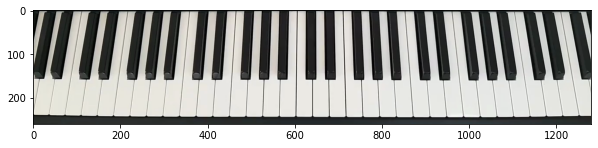

In [34]:
cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')
_, frame = get_frame(cap, 0)
plt.figure(figsize=(10,10))
plt.imshow(frame)
plt.show()

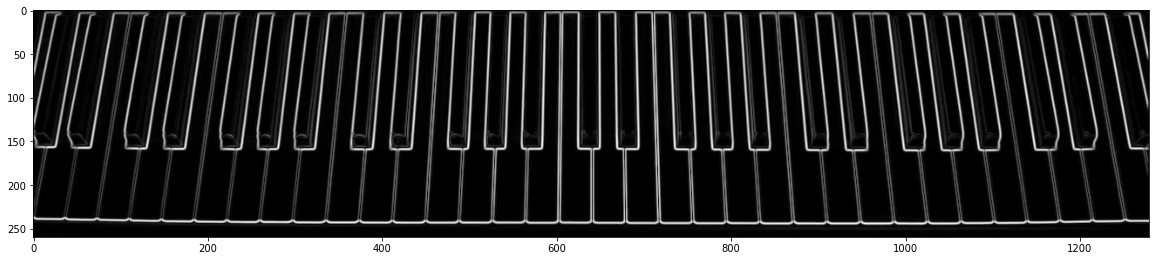

In [35]:
# Sobel or Canny or Hough can be used to detect edges

# Sobel
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
sobel = np.sqrt(sobelx**2 + sobely**2)

# Canny
canny = cv2.Canny(frame, 100, 250)


# Display
plt.figure(figsize=(20,10))
plt.imshow(sobel, cmap='gray')
plt.show()



In [36]:
# use slider for canny

def show_frame_with_canny(threshold1, threshold2):
    _, frame = get_frame(cap, 0)
    edges = cv2.Canny(frame, threshold1, threshold2)
    plt.figure(figsize=(20,10))
    plt.imshow(edges, cmap='gray')
    plt.figure(figsize=(10,10))
    plt.imshow(frame)
    plt.show()

interact(show_frame_with_canny, threshold1=(0, 200, 1), threshold2=(150, 255, 1))


interactive(children=(IntSlider(value=100, description='threshold1', max=200), IntSlider(value=202, descriptio…

<function __main__.show_frame_with_canny(threshold1, threshold2)>

In [37]:
def min_pooling(img, kernel_size):
    img = img.copy()
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    img = cv2.erode(img, kernel, iterations=1)
    img = cv2.dilate(img, kernel, iterations=1)
    return img

In [38]:
# slider for threshold for sobel, and with min pooling and connected components

def show_sobel(threshold):
    _, frame = get_frame(cap, 0)
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
    sobel = np.sqrt(10*sobelx**2 + sobely**2) # 10 is a scaling factor to make the vertical edges more visible
    sobel_with_threshold = sobel.copy()
    sobel_with_threshold[sobel_with_threshold <= threshold] = 255
    sobel_with_threshold[sobel_with_threshold > threshold] = 0
    sobel_with_threshold[0:5,:] = 0 # make a white line to separate the black keys
    sobel_with_threshold = sobel_with_threshold.astype(np.uint8)
    plt.figure(figsize=(20,10))
    plt.imshow(sobel_with_threshold, cmap='gray')
    plt.show()

    ret, labels = cv2.connectedComponents(sobel_with_threshold)
    print(len(np.unique(labels)))
    plt.figure(figsize=(20,10))
    plt.imshow(labels, cmap='gray')
    plt.show()

interact(show_sobel, threshold=(1000, 5000, 1))

interactive(children=(IntSlider(value=3000, description='threshold', max=5000, min=1000), Output()), _dom_clas…

<function __main__.show_sobel(threshold)>

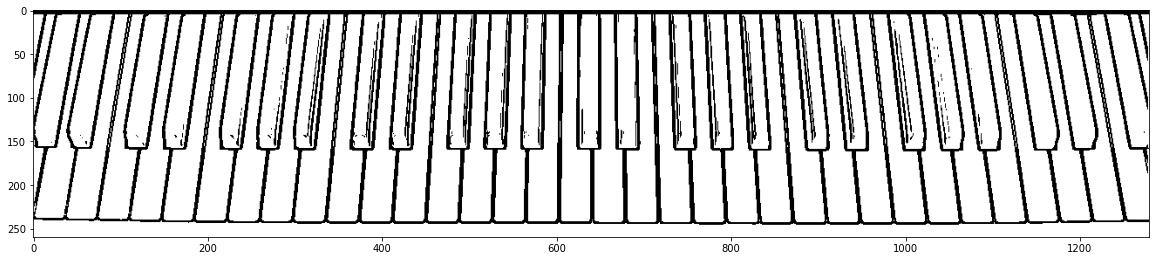

The number of keys is 60


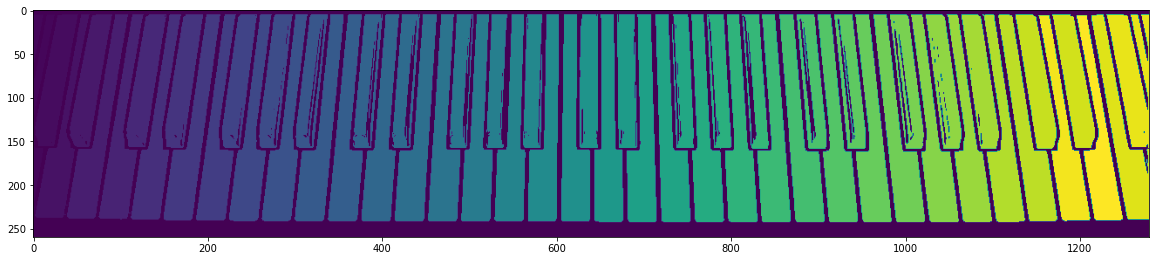

In [39]:
_, frame = get_frame(cap, 0)
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
sobel = np.sqrt(10*sobelx**2 + sobely**2) # 10 is a scaling factor to make the vertical edges more visible

# threshold
threshold = 5000
sobel_with_threshold = sobel.copy()
sobel_with_threshold[sobel_with_threshold <= threshold] = 255
sobel_with_threshold[sobel_with_threshold > threshold] = 0
sobel_with_threshold[0:5,:] = 0 # make a white line to separate the black keys
sobel_with_threshold = sobel_with_threshold.astype(np.uint8)

# min pooling along horizontal axis to remove some holes between the keys where y is between 157 and 240
for i in range(157, 240):
    for j in range(3, 1280-3):
        if (sobel_with_threshold[i, j] == 255
            and (sobel_with_threshold[i, j-1] == 0 or sobel_with_threshold[i, j-2] == 0 or sobel_with_threshold[i, j-3] == 0)
            and (sobel_with_threshold[i, j+1] == 0 or sobel_with_threshold[i, j+2] == 0 or sobel_with_threshold[i, j+3] == 0)):
            sobel_with_threshold[i, j] = 0
plt.figure(figsize=(20,10))
plt.imshow(sobel_with_threshold, cmap='gray')
plt.show()

# get the connected components
ret, labels = cv2.connectedComponents(sobel_with_threshold)

# some connected components are too small, so we remove them
for i in range(1, len(np.unique(labels))):
    if np.sum(labels == i) < 500:
        labels[labels == i] = 0
# the second biggest connected component is the background at the bottom so we remove it
# (the biggest connected component are the edges)
labels[labels == np.argsort(np.bincount(labels.flatten()))[-2]] = 0

# rename the connected components
labels[labels > 0] = 255
labels = labels.astype(np.uint8)
ret, labels = cv2.connectedComponents(labels)
number = len(np.unique(labels))
labels[labels > 0] = labels[labels > 0] #+ 20 # add 20 to the labels to make the regions easier to see
print("The number of keys is", number-1) # -1 because 0 is the background

plt.figure(figsize=(20,10))
plt.imshow(labels)
plt.show()

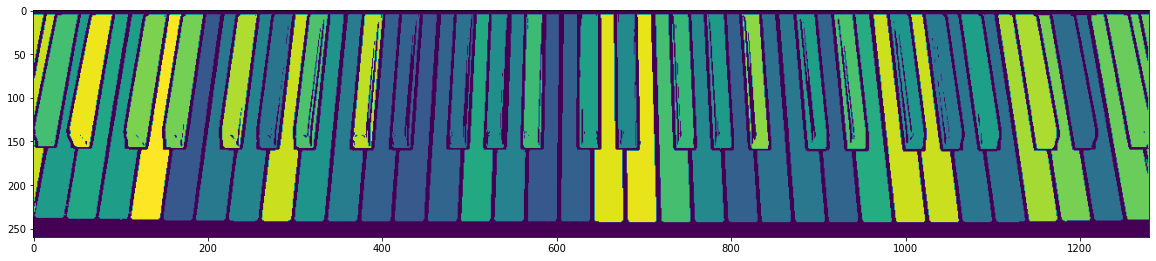

In [40]:
# (optional) assigning random colors to the connected components in order to distinguish them
labels2 = labels.copy()
dictionary = {}
for i in range(1, number+1):
    dictionary[i] = np.random.randint(70, 255)
for i in range(1, number+1):
    labels2[labels2 == i] = dictionary[i]

plt.figure(figsize=(20,10))
plt.imshow(labels2)
plt.show()

In [41]:
# highlighting each keys

def highlight_key(labels, key_number):
    # where labels == key_number, set new_labels to 255,
    # where labels == 0, set new_labels to 0,
    # where labels != key_number and labels != 0, set new_labels to 100
    new_labels = np.zeros_like(labels)
    new_labels[labels == key_number] = 255
    new_labels[labels == 0] = 0
    new_labels[(labels != key_number) & (labels != 0)] = 100
    return new_labels

# slider for key number
def show_key(key_number):
    plt.figure(figsize=(20,10))
    plt.imshow(highlight_key(labels, key_number), cmap='gray')
    plt.show()

interact(show_key, key_number=(1, number-1, 1))

interactive(children=(IntSlider(value=30, description='key_number', max=60, min=1), Output()), _dom_classes=('…

<function __main__.show_key(key_number)>

In [42]:
# the key numbers are not in the right order, so we need to reorder them by using
# the x coordinates of the centroids of the connected components

# get the centroids of the connected components
centroids = [(i, np.mean(np.where(labels == i), axis=1)[1]) for i in range(1, number)]

# reorder the keys
keys = sorted(centroids, key=lambda x: x[1])

# reassigning the labels
new_labels = np.zeros_like(labels)
for i in range(1, number):
    new_labels[labels == keys[i-1][0]] = i

# highlighting each keys
def show_key(key_number):
    plt.figure(figsize=(20,10))
    plt.imshow(highlight_key(new_labels, key_number), cmap='gray')
    plt.show()

interact(show_key, key_number=(1, number-1, 1))



interactive(children=(IntSlider(value=30, description='key_number', max=60, min=1), Output()), _dom_classes=('…

<function __main__.show_key(key_number)>

In [43]:
centroids = [(i,np.mean(np.where(new_labels == i), axis=1)[0])
            for i in range(2, number-1)] # we exclude the first and last keys because they are not complete
# only keep the index of the black keys which have a y-centroid between less than 100
black_keys = [c[0] for c in centroids if c[1] < 100]

In [44]:
# Goal : erase the noise in the black keys
# We will use the fact that the black keys are convex
# So we will find the convex hull of each black key and fill it with white

# get the convex hull of each black key
def get_convex_hull(labels, key_number):
    # get the coordinates of the pixels of the key
    X,Y = np.where(labels == key_number)
    # in order to simplify the convex hull and make things faster, (25% faster)
    # we will only keep the points that are on the border of the key (y < 20 or y > 120)
    #Y = Y[(X < 20) | (X > 120)]
    #X = X[(X < 20) | (X > 120)]
    # get the convex hull
    hull = ConvexHull(np.array([X,Y]).T)
    return hull

# check if a point is inside a convex hull
def is_inside_hull(hull, point):
    # get the vertices of the convex hull
    vertices = hull.points[hull.vertices]
    # get the Delaunay triangulation of the vertices
    tri = Delaunay(vertices)
    # check if the point is inside the convex hull
    return tri.find_simplex(point) >= 0

# fill the convex hull of a black key with white
def fill_hull(labels, key_number):
    new_labels = labels.copy()
    # get the convex hull
    hull = get_convex_hull(new_labels, key_number)
    # fill the convex hull with white
    # get xmin, xmax, ymin, ymax of the convex hull to limit the search
    xmin = np.min(hull.points[hull.vertices,0])
    xmax = np.max(hull.points[hull.vertices,0])
    ymin = np.min(hull.points[hull.vertices,1])
    ymax = np.max(hull.points[hull.vertices,1])
    for x in range(int(xmin), int(xmax)+1):
        for y in range(int(ymin), int(ymax)+1):
            if new_labels[x,y] == 0 and is_inside_hull(hull, (x,y)):
                new_labels[x,y] = key_number
    return new_labels

# fill the convex hull of each black key with white
new_labels_filled = new_labels.copy()
for i in tqdm(black_keys):
    new_labels_filled = fill_hull(new_labels_filled, i)


100%|██████████| 24/24 [00:02<00:00,  8.60it/s]


In [45]:
# highlighting each keys
def show_key(key_number):
    plt.figure(figsize=(20,10))
    plt.imshow(highlight_key(new_labels_filled, key_number), cmap='gray')
    plt.show()

interact(show_key, key_number=(1, number-1, 1))

interactive(children=(IntSlider(value=30, description='key_number', max=60, min=1), Output()), _dom_classes=('…

<function __main__.show_key(key_number)>

In [46]:
def highlight_key_from_image(image, labels, key_number):
    new_image = image.copy()
    new_image[labels == key_number] = [0,240,0]
    return new_image

def show_key_from_image(key_number):
    plt.figure(figsize=(20,10))
    plt.imshow(highlight_key_from_image(frame, new_labels_filled, key_number))
    plt.show()

interact(show_key_from_image, key_number=(1, number, 1))

interactive(children=(IntSlider(value=31, description='key_number', max=61, min=1), Output()), _dom_classes=('…

<function __main__.show_key_from_image(key_number)>

# Trying to fix the problem of the sligthly moving piano

<video controls src="mp4/output_full_code/1_piano_isolate_hands.mp4">animation</video>

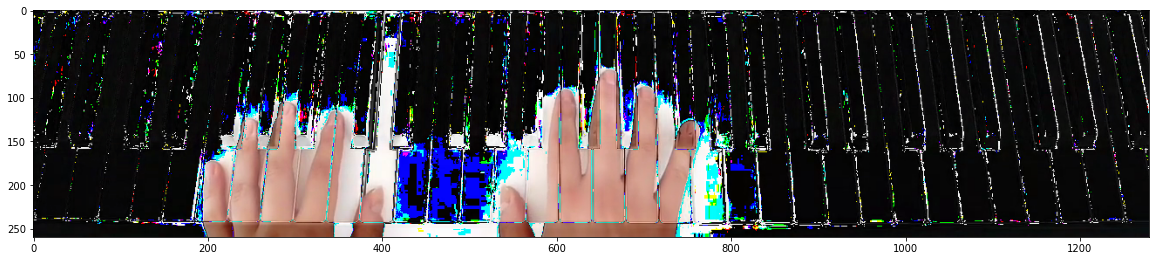

In [47]:
cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')
_, mask = get_frame(cap, 0)
_, frame = get_frame(cap, 100)
plt.figure(figsize=(20,10))
plt.imshow(frame - mask)

In [48]:
# slider to see the difference between two frames
# first parameter is frame number

def show_frame_difference(frame_number):
    _, frame1 = get_frame(cap, 0)
    _, frame2 = get_frame(cap, frame_number)
    plt.figure(figsize=(20,10))
    difference = frame2 - frame1 - 5
    gray = cv2.cvtColor(difference, cv2.COLOR_RGB2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.show()

interact(show_frame_difference, frame_number=(0, 230, 1))

interactive(children=(IntSlider(value=115, description='frame_number', max=230), Output()), _dom_classes=('wid…

<function __main__.show_frame_difference(frame_number)>

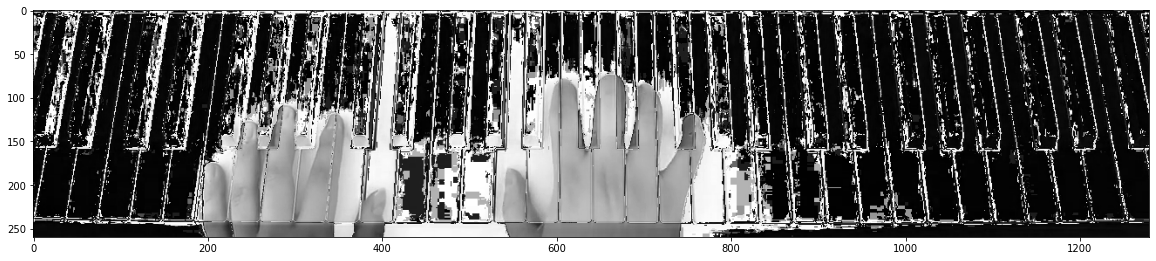

In [49]:
_, frame1 = get_frame(cap, 0)
_, frame2 = get_frame(cap, 115)
plt.figure(figsize=(20,10))
difference = frame2 - frame1 - 5
gray = cv2.cvtColor(difference, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()


# Get the hand region

The goal is to isolate the hands and highlight them. It is the continuation of the section "Mask".

In [50]:
cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')

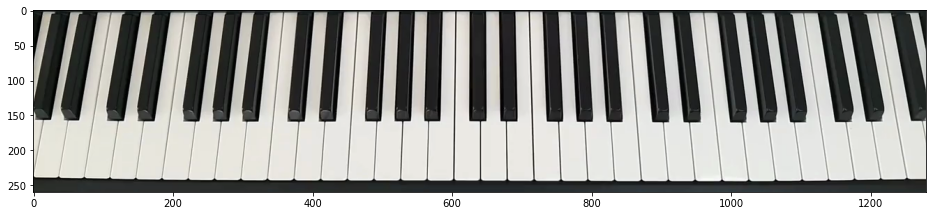

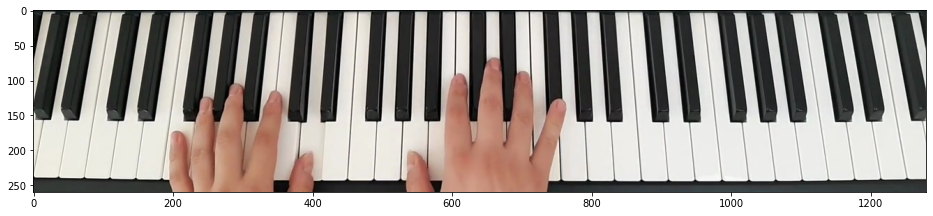

In [51]:
_, frame_mask = get_frame(cap, 0)
_, frame = get_frame(cap, 100)
show_frame(cap, 0)
show_frame(cap, 100)

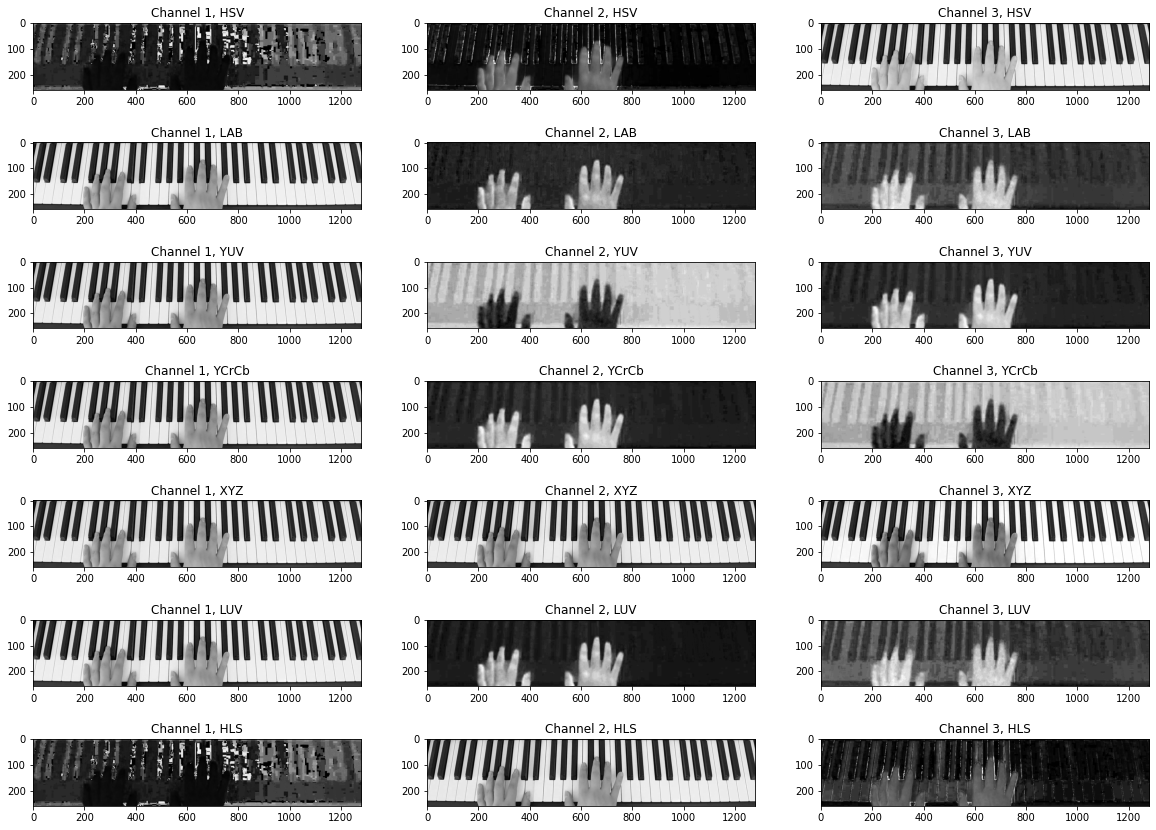

In [52]:
# 1st strategy : we use color conversion to see the difference between the hands and the piano

hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
lab = cv2.cvtColor(frame, cv2.COLOR_RGB2LAB)
yuv = cv2.cvtColor(frame, cv2.COLOR_RGB2YUV)
ycrcb = cv2.cvtColor(frame, cv2.COLOR_RGB2YCrCb)
xyz = cv2.cvtColor(frame, cv2.COLOR_RGB2XYZ)
luv = cv2.cvtColor(frame, cv2.COLOR_RGB2LUV)
hls = cv2.cvtColor(frame, cv2.COLOR_RGB2HLS)

all_frames = [hsv, lab, yuv, ycrcb, xyz, luv, hls]
name = ['HSV', 'LAB', 'YUV', 'YCrCb', 'XYZ', 'LUV', 'HLS']
# now the three channels of all different with subplot(7,3,1) to subplot(7,3,21)

plt.figure(figsize=(20,15))
for i in range(7):
    plt.subplot(7,3,3*i+1)
    plt.imshow(all_frames[i][:,:,0], cmap='gray')
    plt.title('Channel 1, ' + name[i])
    plt.subplot(7,3,3*i+2)
    plt.imshow(all_frames[i][:,:,1], cmap='gray')
    plt.title('Channel 2, ' + name[i])
    plt.subplot(7,3,3*i+3)
    plt.imshow(all_frames[i][:,:,2], cmap='gray')
    plt.title('Channel 3, ' + name[i])


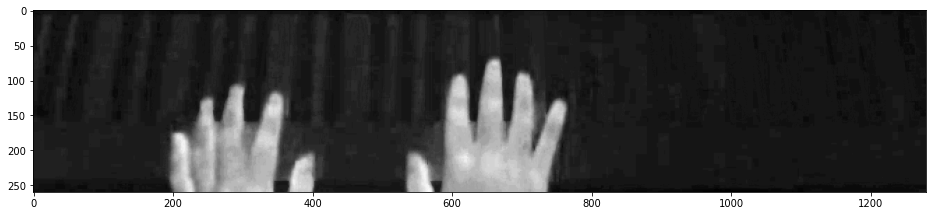

In [53]:
# We choose LUV channel 2 for the detection
# We can combine different conversions to get better results, but we will not do it here

frame_luv2 = cv2.cvtColor(frame, cv2.COLOR_RGB2LUV)[...,1] 
plt.figure(figsize=(16,6))
plt.imshow(frame_luv2, cmap='gray')
plt.show()

In [54]:
# 2nd strategy : the piano is black or white (n,n,n), while the hands are beige (a,b,c) different
# we will use the standard deviation of the color

def using_std(threshold):
    new_frame = frame.std(axis=2)
    new_frame[new_frame < threshold] = 0
    new_frame[new_frame >= threshold] = 255
    plt.figure(figsize=(16,6))
    plt.imshow(new_frame, cmap='gray')
    plt.show()

interact(using_std, threshold=(0, 100, 1))

interactive(children=(IntSlider(value=50, description='threshold'), Output()), _dom_classes=('widget-interact'…

<function __main__.using_std(threshold)>

In [55]:
# 3rd strategy : the ratio between R and G is between a lower and upper bound
# use slider

def show_ratio(threshold1,threshold2):
    frame_ratio = frame[...,0].astype(float) / (frame[...,1].astype(float)+1)
    frame_ratio[frame_ratio < threshold1] = 0
    frame_ratio[frame_ratio > threshold2] = 0
    frame_ratio[frame_ratio > 0] = 255
    plt.figure(figsize=(16,6))
    plt.imshow(frame_ratio, cmap='gray')
    plt.show()

interact(show_ratio, threshold1=(0, 1, 0.01), threshold2=(0.5, 2, 0.01))


interactive(children=(FloatSlider(value=0.0, description='threshold1', max=1.0, step=0.01), FloatSlider(value=…

<function __main__.show_ratio(threshold1, threshold2)>

In [56]:
# We use the 2nd strategy with a threshold of 20

cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')
fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('mp4/output_full_code/4_hand_detector.mp4', # or .mkv
    fourcc, cap.get(cv2.CAP_PROP_FPS),
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm(range(n)):
    _, frame = cap.read()
    if not ret:
        break
    frame = frame.std(axis=2)
    frame[frame < 20] = 0
    frame[frame >= 20] = 255
    frame = frame.astype(np.uint8)
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    out.write(frame)

cap.release()
out.release()

OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
100%|██████████| 6014/6014 [01:07<00:00, 89.45it/s]


# Detect fingertips

In [57]:
cap = cv2.VideoCapture('mp4/output_full_code/4_hand_detector.mp4')

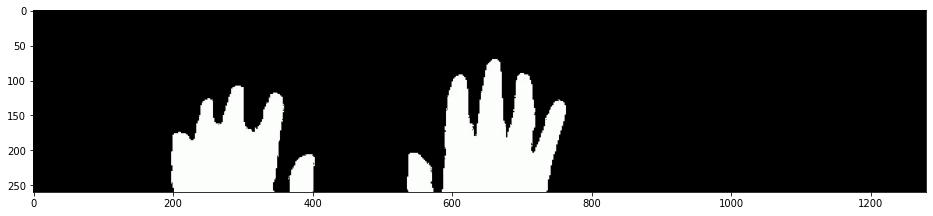

In [58]:
_, frame = get_frame(cap, 100)
show_frame(cap, 100)

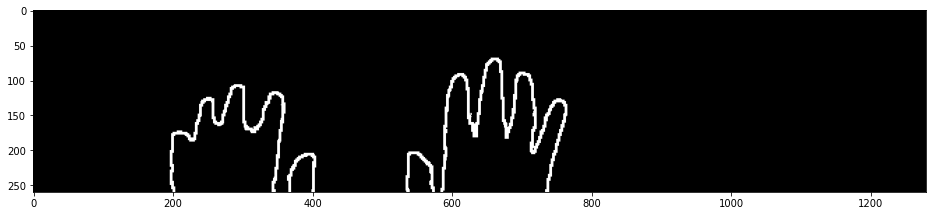

In [59]:
# sobel

gray = (cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY))
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
sobel = np.sqrt(sobelx**2 + sobely**2)
sobel[sobel < 300] = 0
sobel[sobel >= 300] = 255
sobel = sobel.astype(np.uint8)
plt.figure(figsize=(16,6))
plt.imshow(sobel, cmap='gray')
plt.show()

(1, 23, 3)


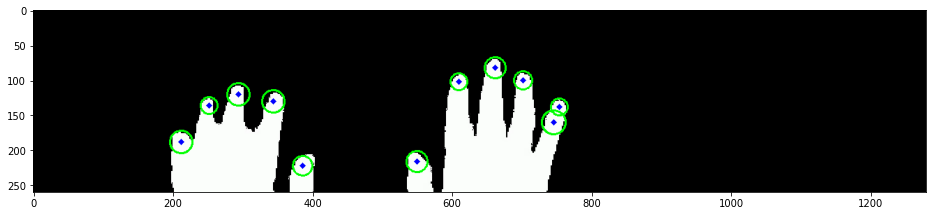

In [60]:
# The goal is to make circles on fingertips
# We will use the HoughCircles function

circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 20,
                            param1=2, param2=10, minRadius=1, maxRadius=20)
circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 20,
                            param1=2, param2=8, minRadius=1, maxRadius=20)
print(circles.shape)
circles = np.uint16(np.around(circles))
frame_with_circle = frame.copy()
for i in circles[0,:]:
    # only keep circles whose center is in the hand (white)
    # and whose center is not too far from the tip of the finger (black)
    if frame[i[1], i[0], 0] > 230 and frame[i[1]-30, i[0], 0] < 100:
        # draw the outer circle
        cv2.circle(frame_with_circle,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(frame_with_circle,(i[0],i[1]),2,(0,0,255),3)
plt.figure(figsize=(16,6))
plt.imshow(frame_with_circle)


In [61]:
# dp, minDist, param1, param2, minRadius, maxRadius
# find the best parameters with sliders

def show_circles(dp, minDist, param1, param2, minRadius, maxRadius):
    circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = dp, minDist = minDist,
                                param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    circles = np.uint16(np.around(circles))
    frame_with_circle = frame.copy()
    for i in circles[0,:]:
        # only keep circles whose center is in the hand (white)
        # and whose center is not too far from the tip of the finger (black)
        if frame[i[1], i[0], 0] > 230 and frame[i[1]-30, i[0], 0] < 100:
            # draw the outer circle
            cv2.circle(frame_with_circle,(i[0],i[1]),i[2],(0,255,0),2)
            # draw the center of the circle
            cv2.circle(frame_with_circle,(i[0],i[1]),2,(0,0,255),3)
    plt.figure(figsize=(16,6))
    plt.imshow(frame_with_circle)

interact(show_circles, dp=(1, 1, 1), minDist=(1, 100, 1), param1=(1, 1, 1), param2=(1, 20, 1),
        minRadius=(0, 30, 1), maxRadius=(0, 50, 1))
    
# dp = 1, minDist = 30, param1=1, param2=8, minRadius=0, maxRadius=20)

interactive(children=(IntSlider(value=1, description='dp', max=1, min=1), IntSlider(value=50, description='min…

<function __main__.show_circles(dp, minDist, param1, param2, minRadius, maxRadius)>

In [62]:
# Do for all frames

cap = cv2.VideoCapture('mp4/output_full_code/4_hand_detector.mp4')
fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('mp4/output_full_code/5_hand_detector_circles.mp4', # or .mkv
    fourcc, cap.get(cv2.CAP_PROP_FPS),
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm(range(n)):
    _, frame = cap.read()
    if not ret:
        break
    gray = (cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY))
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel[sobel < 300] = 0
    sobel[sobel >= 300] = 255
    sobel = sobel.astype(np.uint8)
    circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 30,
                                param1=1, param2=8, minRadius=0, maxRadius=20)
    frame_with_circle = frame.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            # only keep circles whose center is in the hand (white)
            # and whose center is not too far from the tip of the finger (black)
            if frame[i[1]-1, i[0]-1, 0] > 230 and frame[max(0,i[1]-30), i[0]-1, 0] < 100: # -1 to avoid out of bounds
                # draw the outer circle
                cv2.circle(frame_with_circle,(i[0],i[1]),i[2],(0,255,0),2)
                # draw the center of the circle
                cv2.circle(frame_with_circle,(i[0],i[1]),2,(0,0,255),3)
    out.write(frame_with_circle)
cap.release()
out.release()

OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
100%|██████████| 6014/6014 [00:38<00:00, 158.05it/s]


In [63]:
# Do for all frames with sliders

def show_circles(number_frame):
    cap = cv2.VideoCapture('mp4/output_full_code/4_hand_detector.mp4')
    ret, frame = get_frame(cap, number_frame)
    if not ret:
        return
    gray = (cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY))
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel[sobel < 300] = 0
    sobel[sobel >= 300] = 255
    sobel = sobel.astype(np.uint8)
    circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 30,
                                param1=1, param2=8, minRadius=0, maxRadius=20)
    frame_with_circle = frame.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            # only keep circles whose center is in the hand (white)
            # and whose center is not too far from the tip of the finger (black)
            if frame[i[1]-1, i[0]-1, 0] > 230 and frame[max(0,i[1]-30), i[0]-1, 0] < 100: # -1 to avoid out of bounds
                # draw the outer circle
                cv2.circle(frame_with_circle,(i[0],i[1]),i[2],(0,255,0),2)
                # draw the center of the circle
                cv2.circle(frame_with_circle,(i[0],i[1]),2,(0,0,255),3)
    plt.figure(figsize=(16,6))
    plt.imshow(frame_with_circle)
    cap.release()

interact(show_circles, number_frame=(0, 1000, 1))

interactive(children=(IntSlider(value=500, description='number_frame', max=1000), Output()), _dom_classes=('wi…

<function __main__.show_circles(number_frame)>

In [64]:
# pipeline to get circles

def pipeline_get_circles(frame):
    gray = (cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY))
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel[sobel < 300] = 0
    sobel[sobel >= 300] = 255
    sobel = sobel.astype(np.uint8)
    circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 30,
                                param1=1, param2=8, minRadius=0, maxRadius=20)
    return circles

In [65]:
# pipeline to draw circles

def pipeline_draw_circles(frame, circles):
    good_circles = []
    frame_with_circle = frame.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            # only keep circles whose center is in the hand (white)
            # and whose center is not too far from the tip of the finger (black)
            if frame[i[1]-1, i[0]-1, 0] > 230 and frame[max(0,i[1]-30), i[0]-1, 0] < 100: # -1 to avoid out of bounds
                # add the circle to the list of good circles
                good_circles.append([i[0], i[1], i[2]])
                # draw the outer circle
                cv2.circle(frame_with_circle,(i[0],i[1]),i[2],(0,255,0),2)
                # draw the center of the circle
                cv2.circle(frame_with_circle,(i[0],i[1]),2,(0,0,255),3)
    return good_circles, frame_with_circle

The first frame with 10 fingers is frame number 36


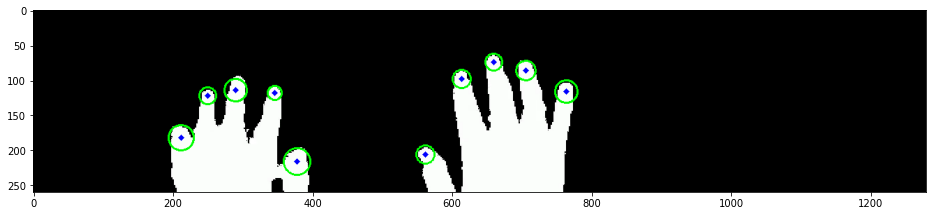

In [66]:
# get the first frame with 10 fingers

cap = cv2.VideoCapture('mp4/output_full_code/4_hand_detector.mp4')
i = 0
ret, frame = get_frame(cap, i)
circles = pipeline_get_circles(frame)
good_circles, frame_with_circle = pipeline_draw_circles(frame, circles)
while len(good_circles) != 10:
    i = i + 1
    ret, frame = get_frame(cap, i)
    circles = pipeline_get_circles(frame)
    good_circles, frame_with_circle = pipeline_draw_circles(frame, circles)
cap.release()

print('The first frame with 10 fingers is frame number', i)
plt.figure(figsize=(16,6))
plt.imshow(frame_with_circle)

100%|██████████| 6014/6014 [00:39<00:00, 150.36it/s]


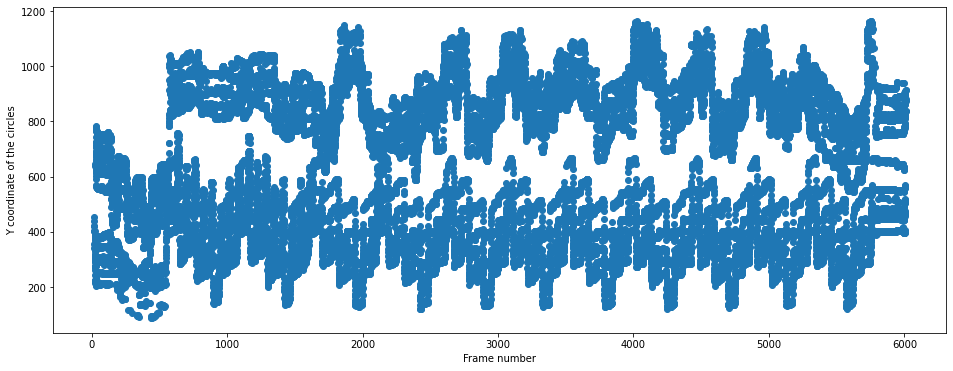

In [67]:
# plot all X coordinates of the circles against the frame number

cap = cv2.VideoCapture('mp4/output_full_code/4_hand_detector.mp4')
X, Y = [], []
n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm(range(n)):
    ret, frame = cap.read()
    if ret == False:
        break
    circles = pipeline_get_circles(frame)
    good_circles, frame_with_circle = pipeline_draw_circles(frame, circles)
    for x, _, _ in good_circles:
        X.append(i)
        Y.append(x)
cap.release()
plt.figure(figsize=(16,6))
plt.scatter(X, Y)
plt.xlabel('Frame number')
plt.ylabel('Y coordinate of the circles')
plt.show()

In [68]:
# save the data as csv

df = pd.DataFrame({'frame': X, 'x': Y})
df.to_csv('data/hand_detector.csv', index=False)

# Clustering time series ?

From the X-points, try to find the 10 fingers.

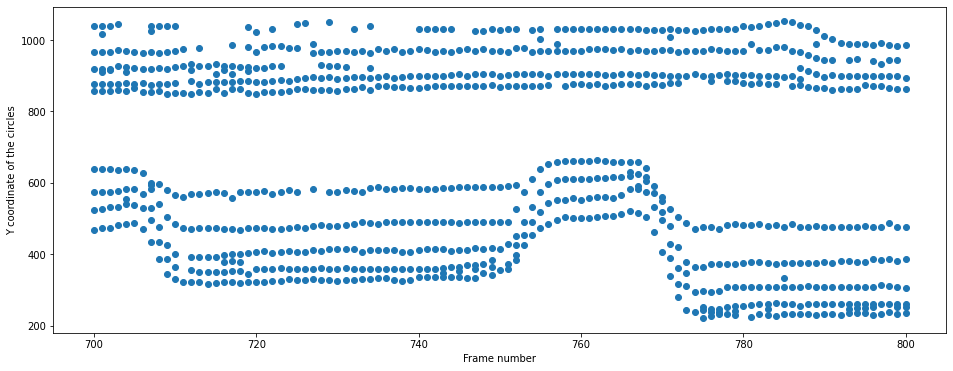

In [69]:
# import the data

df = pd.read_csv('data/hand_detector.csv')
df.head()

# plot the data
n = df['frame'].max()
begin = 700
end = 800
plt.figure(figsize=(16,6))
plt.scatter(df['frame'][df['frame'] >= begin][df['frame'] <= end], df['x'][df['frame'] >= begin][df['frame'] <= end])
plt.xlabel('Frame number')
plt.ylabel('Y coordinate of the circles')
plt.show()

We can see that there are 10 fingers (curves) but also some noise

When there are more than 10 fingers, we have to find which ones are the real ones

We can use adjacent frames which have 10 fingers to find the real ones ?

In [70]:
# get all x coordinates from a frame

def get_x_coordinates(df, frame_number):
    return df['x'][df['frame'] == frame_number].sort_values().values

get_x_coordinates(df, 700)

array([ 468,  524,  574,  638,  856,  876,  920,  966, 1038])

In [71]:
# number of fingers for each frame
number_of_fingers = np.array([len(get_x_coordinates(df, i)) for i in range(n)])


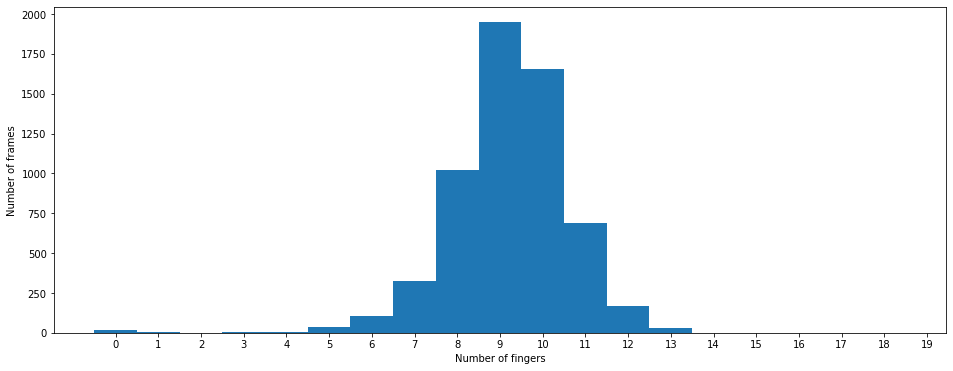

In [72]:
# histogram of number of frames with x fingers

plt.figure(figsize=(16,6))
plt.hist(number_of_fingers, bins=range(0, 20), align='left')
plt.xticks(range(0, 20))
plt.xlabel('Number of fingers')
plt.ylabel('Number of frames')
plt.show()


In [73]:
# look at adjacent frames with 10 fingers

def adjacent_frames_with_10(number_of_fingers, n, window_size):
    # number_of_fingers: array of number of fingers in each frame
    # n: number of the frame
    # window_size: number of frames to check on each side of the frame n

    index = []
    for i in range(n - window_size, n + window_size + 1):
        if i >= 0 and i < len(number_of_fingers) and number_of_fingers[i] == 10:
            index.append(i)
    return index

In [74]:
# testing the function
more_10_fingers = np.where(number_of_fingers > 10)[0]

k = 10
no_frame = more_10_fingers[k]
print(no_frame)
adjacent_frames_with_10(number_of_fingers, no_frame, 10)

52


[48, 50, 55, 56]

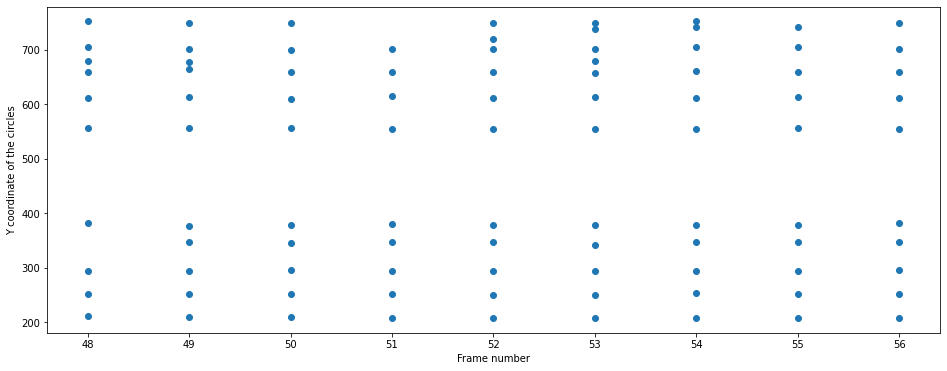

In [75]:
# plot the testing
L = adjacent_frames_with_10(number_of_fingers, no_frame, 10)+[no_frame]
L.sort()

plt.figure(figsize=(16,6))
plt.scatter(df['frame'][df['frame'] >= L[0]][df['frame'] <= L[-1]], df['x'][df['frame'] >= L[0]][df['frame'] <= L[-1]])
plt.xlabel('Frame number')
plt.ylabel('Y coordinate of the circles')
plt.show()

# the problem at frame 48 is that there is hand with 4 fingers and the other hand with 6 fingers

In [76]:
# dendrogram for each frame (with sliders)

def plot_dendrogram(frame_number):
    x = get_x_coordinates(df, frame_number)
    Z = linkage(x.reshape(-1, 1), 'ward')
    print(Z)
    plt.figure(figsize=(16,6))
    dendrogram(Z)
    plt.show()

interact(plot_dendrogram, frame_number=widgets.IntSlider(min=0, max=n-1, step=1, value=55))

interactive(children=(IntSlider(value=55, description='frame_number', max=6009), Output()), _dom_classes=('wid…

<function __main__.plot_dendrogram(frame_number)>

In [77]:
# In theory, there are two hands, so there are two clusters
# So we can use the number of clusters to detect the number of fingers

# We use linkage to get the clusters which should be at linkage[-3][-1] and linkage[-2][-1]

def get_clusters(frame_number):
    x = get_x_coordinates(df, frame_number)
    if len(x) < 5:
        return (0,0)
    Z = linkage(x.reshape(-1, 1), 'ward')
    return int(Z[-3][-1]), int(Z[-2][-1])

# testing the function
get_clusters(54)


(5, 6)

In [78]:
# If get_clusters returns (5,5), then there are 10 fingers (5 on each hand)

good_frames = []
for i in tqdm(range(n)):
    clusters = get_clusters(i)
    if clusters[0] == clusters[1] == 5:
        good_frames.append(i)
good_frames_bool = np.zeros(n, dtype=bool)
good_frames_bool[good_frames] = True
print('There are', len(good_frames), 'frames with 10 fingers, 5 on each hand')

100%|██████████| 6010/6010 [00:00<00:00, 6475.39it/s]

There are 1036 frames with 10 fingers, 5 on each hand


52
[36, 50, 55, 56, 72]


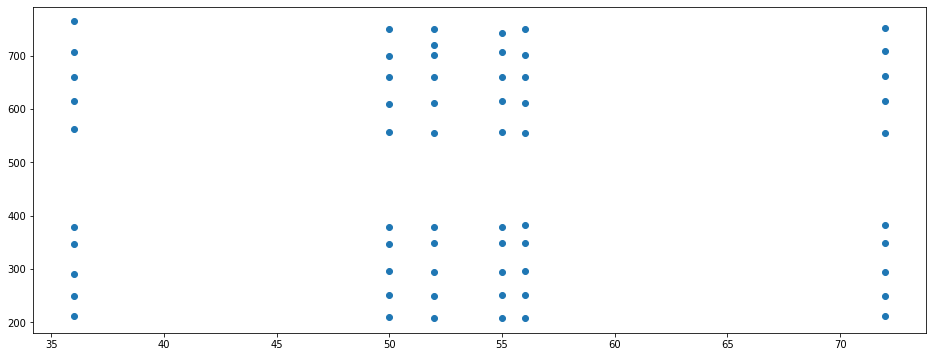

In [79]:
def adjacent_frames_with_good_10(good_frames_bool, n, window_size):
    index = []
    for i in range(n - window_size, n + window_size + 1):
        if i >= 0 and i < len(good_frames_bool) and good_frames_bool[i]:
            index.append(i)
    return index

# testing the function
k = 10
no_frame = more_10_fingers[k]
print(no_frame)
L = adjacent_frames_with_good_10(good_frames_bool, no_frame, 20)
print(L)

# plot the testing
plt.figure(figsize=(16,6))
plt.scatter(df['frame'][df['frame'].isin(L+[no_frame])], df['x'][df['frame'].isin(L+[no_frame])])

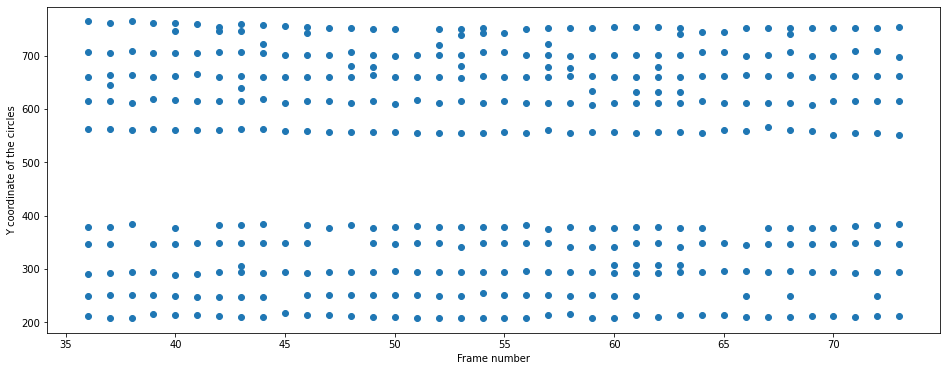

In [80]:
plt.figure(figsize=(16,6))
plt.scatter(df['frame'][df['frame'] >= 36][df['frame'] <= 73], df['x'][df['frame'] >= 36][df['frame'] <= 73])
plt.xlabel('Frame number')
plt.ylabel('Y coordinate of the circles')
plt.show()

In [81]:
# I DON'T KNOW WHAT TO DO WITH THIS
# Should we care ? We just want the keys to be above the hand

# Keys pressed accordingly to the hand position

In [82]:
image = cv2.imread('pictures/frame0.png')

def pipeline_isolate_key(image):

    # sobel
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
    sobel = np.sqrt(10*sobelx**2 + sobely**2) # 10 is a scaling factor to make the vertical edges more visible

    # threshold
    threshold = 5000
    sobel_with_threshold = sobel.copy()
    sobel_with_threshold[sobel_with_threshold <= threshold] = 255
    sobel_with_threshold[sobel_with_threshold > threshold] = 0
    sobel_with_threshold[0:5,:] = 0 # make a white line to separate the black keys
    sobel_with_threshold = sobel_with_threshold.astype(np.uint8)
    #plt.figure(figsize=(20,10))
    #plt.imshow(sobel_with_threshold, cmap='gray')
    #plt.show()

    # min pooling along horizontal axis to remove some holes between the keys where y is betweent 157 and 240
    for i in range(157, 240):
        for j in range(3, 1280-3):
            if (sobel_with_threshold[i, j] == 255
                and (sobel_with_threshold[i, j-1] == 0 or sobel_with_threshold[i, j-2] == 0 or sobel_with_threshold[i, j-3] == 0)
                and (sobel_with_threshold[i, j+1] == 0 or sobel_with_threshold[i, j+2] == 0 or sobel_with_threshold[i, j+3] == 0)):
                sobel_with_threshold[i, j] = 0

    # get the connected components
    ret, labels = cv2.connectedComponents(sobel_with_threshold)

    # some connected components are too small, so we remove them
    for i in range(1, len(np.unique(labels))):
        if np.sum(labels == i) < 500:
            labels[labels == i] = 0
    # the second biggest connected component is the background at the bottom so we remove it (the biggest connected component are the edges)
    labels[labels == np.argsort(np.bincount(labels.flatten()))[-2]] = 0

    # rename the connected components
    labels[labels > 0] = 255
    labels = labels.astype(np.uint8)
    ret, labels = cv2.connectedComponents(labels)
    number = len(np.unique(labels))
    labels[labels > 0] = labels[labels > 0] #+ 20 # add 20 to the labels to make the regions easier to see
    print("The number of keys is", number-1) # -1 because 0 is the background

    # the key numbers are not in the right order, so we need to reorder them by using
    # the x coordinates of the centroids of the connected components

    # get the centroids of the connected components
    centroids = [(i, np.mean(np.where(labels == i), axis=1)[1]) for i in range(1, number)]

    # reorder the keys
    keys = sorted(centroids, key=lambda x: x[1])

    # reassigning the labels
    new_labels = np.zeros_like(labels)
    for i in range(1, number):
        new_labels[labels == keys[i-1][0]] = i

    # Goal : erase the noise in the black keys
    # We will use the fact that the black keys are convex
    # So we will find the convex hull of each black key and fill it with white
    
    centroids = [(i,np.mean(np.where(new_labels == i), axis=1)[0])
                for i in range(2, number-1)] # we exclude the first and last keys because they are not complete
    # only keep the index of the black keys which have a y-centroid between less than 100
    black_keys = [c[0] for c in centroids if c[1] < 100]

    # get the convex hull of each black key
    def get_convex_hull(labels, key_number):
        # get the coordinates of the pixels of the key
        X,Y = np.where(labels == key_number)
        # get the convex hull
        hull = ConvexHull(np.array([X,Y]).T)
        return hull

    # check if a point is inside a convex hull
    def is_inside_hull(hull, point):
        # get the vertices of the convex hull
        vertices = hull.points[hull.vertices]
        # get the Delaunay triangulation of the vertices
        tri = Delaunay(vertices)
        # check if the point is inside the convex hull
        return tri.find_simplex(point) >= 0

    # fill the convex hull of a black key with white
    def fill_hull(labels, key_number):
        new_labels = labels.copy()
        # get the convex hull
        hull = get_convex_hull(new_labels, key_number)
        # fill the convex hull with white
        # get xmin, xmax, ymin, ymax of the convex hull to limit the search
        xmin = np.min(hull.points[hull.vertices,0])
        xmax = np.max(hull.points[hull.vertices,0])
        ymin = np.min(hull.points[hull.vertices,1])
        ymax = np.max(hull.points[hull.vertices,1])
        for x in range(int(xmin), int(xmax)+1):
            for y in range(int(ymin), int(ymax)+1):
                if new_labels[x,y] == 0 and is_inside_hull(hull, (x,y)):
                    new_labels[x,y] = key_number
        return new_labels

    # fill the convex hull of each black key with white
    new_labels_filled = new_labels.copy()
    for i in black_keys:
        new_labels_filled = fill_hull(new_labels_filled, i)
    
    return new_labels_filled


# highlight each keys
# where labels == key_number, set new_labels to 255,
# where labels == 0, set new_labels to 0,
# where labels != key_number and labels != 0, set new_labels to 100
def highlight_key(labels, key_number):
    new_labels = np.zeros_like(labels)
    new_labels[labels == key_number] = 255
    new_labels[labels == 0] = 0
    new_labels[(labels != key_number) & (labels != 0)] = 100
    return new_labels

labels = pipeline_isolate_key(image)
number = len(np.unique(labels))-1
X_centroids = [np.mean(np.where(labels == i), axis=1)[1] for i in range(number)]

def highlight_key_from_image(image, labels, key_number):
    new_image = image.copy()
    new_image[labels == key_number] = [0,255,0]
    return new_image

def show_key_from_image(key_number):
    plt.figure(figsize=(20,10))
    plt.imshow(highlight_key_from_image(image, labels, key_number))
    plt.show()

interact(show_key_from_image, key_number=(1, number, 1))

The number of keys is 60


interactive(children=(IntSlider(value=30, description='key_number', max=60, min=1), Output()), _dom_classes=('…

<function __main__.show_key_from_image(key_number)>

In [83]:
cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')

frame0 = get_frame(cap, 0)[1]
frame = get_frame(cap, 100)[1]

In [84]:
# with sliders
def show_frame_from_video(frame_number):
    ret, frame = get_frame(cap, frame_number)
    if ret:
        plt.figure(figsize=(16,6))
        plt.imshow(frame-frame0)
        plt.show()
    else:
        print('Frame not found')

n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
interact(show_frame_from_video, frame_number=widgets.IntSlider(min=0, max=n, step=1, value=1574))


interactive(children=(IntSlider(value=1574, description='frame_number', max=6014), Output()), _dom_classes=('w…

<function __main__.show_frame_from_video(frame_number)>

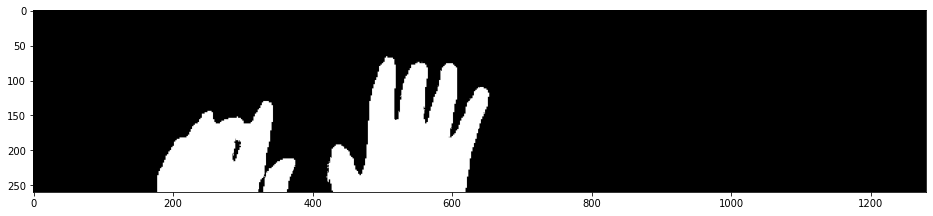

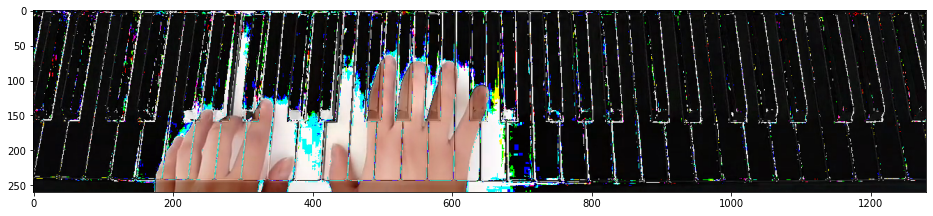

In [85]:
cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')

n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
no_frame = 172 #1574 #184 # 106 #1574 # 1062

def isolate_hands(cap, frame_number):
    ret, frame = get_frame(cap, frame_number)
    frame = frame.std(axis=2)
    frame[frame < 20] = 0
    frame[frame >= 20] = 255
    frame = frame.astype(np.uint8)
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    return frame

def difference(cap, frame_number):
    ret, frame0 = get_frame(cap, 0)
    ret, frame = get_frame(cap, frame_number)
    return frame-frame0

image1 = isolate_hands(cap, no_frame)
image2 = difference(cap, no_frame)
plt.figure(figsize=(16,6))
plt.imshow(image1)
plt.show()
plt.figure(figsize=(16,6))
plt.imshow(image2)
plt.show()


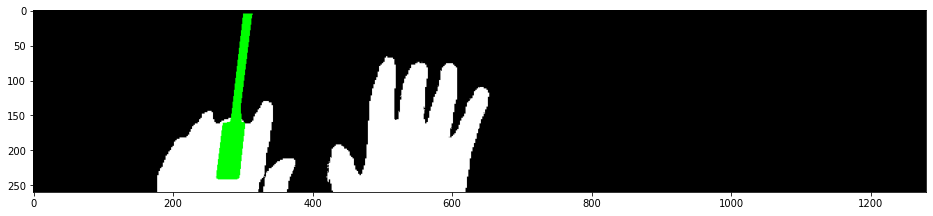

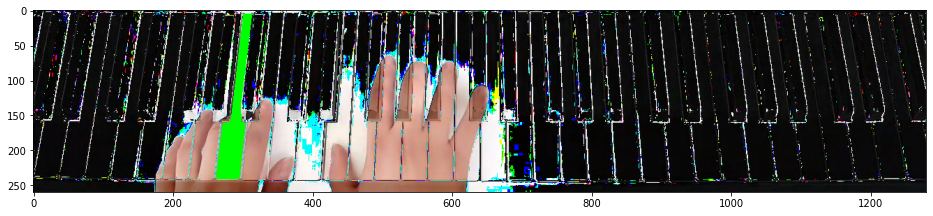

In [86]:
plt.figure(figsize=(16,6))
plt.imshow(highlight_key_from_image(image1, labels, 15))
plt.show()
plt.figure(figsize=(16,6))
plt.imshow(highlight_key_from_image(image2, labels, 15))
plt.show()

[172.63430613 189.28826683 193.44550328]


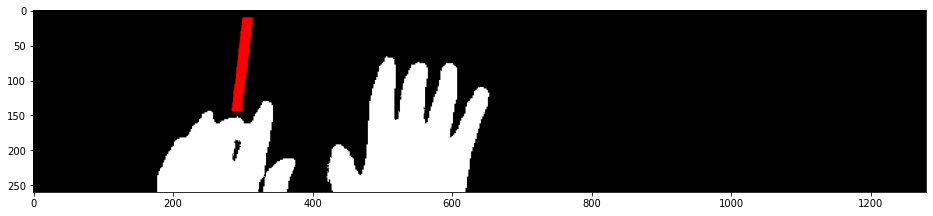

In [87]:
# We check if the key k is pressed by checking all pixels in the key k that are not in the hands

def get_list_pixels(image_hand, key_number, above = False): # above > 0 if we want the pixels to be far from fingers
    result = np.where((labels == key_number) & (image_hand[:,:,0] < 10))
    if not above:
        return result
    pixels_hided = np.where((labels == key_number) & (image_hand[:,:,0] > 200))
    # pixels around the hand shouldn't be considered because the color is influenced
    if len(pixels_hided[0]) > 0:
        highest_pixel = pixels_hided[0].min()
    else :
        highest_pixel = 270 # in fact, we shouldn't consider this because no finger above the key
    return (result[0][(result[0] > 10) & (result[0] <= min(170,max(0,highest_pixel-above)))],
            result[1][(result[0] > 10) & (result[0] <= min(170,max(0,highest_pixel-above)))])

def average_color(image, list_pixels):
    return np.mean(image[list_pixels[0], list_pixels[1]], axis=0)

list_testing = get_list_pixels(image1, 15, 10)
print(average_color(image2, list_testing))

plt.figure(figsize=(16,6))
plt.imshow(image1)
plt.scatter(list_testing[1], list_testing[0], s=1, c='r')
plt.show()

In [88]:
# sliders

def show_pixels_checked(key_number):
    list_testing = get_list_pixels(image1, key_number, 10)
    color = average_color(image2, list_testing)
    plt.figure(figsize=(16,6))
    plt.imshow(image1)
    if all(color > 200):
        plt.scatter(list_testing[1], list_testing[0], s=1, c='g')
    else :
        plt.scatter(list_testing[1], list_testing[0], s=1, c='r')
    plt.show()
    print(average_color(image2, list_testing))

interact(show_pixels_checked, key_number=(1, 60, 1))

interactive(children=(IntSlider(value=30, description='key_number', max=60, min=1), Output()), _dom_classes=('…

<function __main__.show_pixels_checked(key_number)>

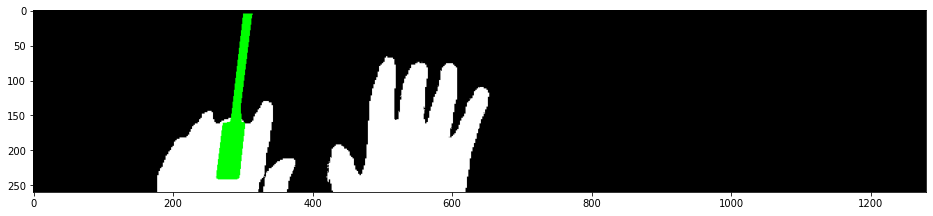

In [89]:
# highlight the keys that are pressed (above threshold)

centroids = [(i,np.mean(np.where(labels == i), axis=1)[0])
                for i in range(2, number-1)] # we exclude the first and last keys because they are not complete
# only keep the index of the black keys which have a y-centroid between less than 100
black_keys = [c[0] for c in centroids if c[1] < 100]
white_keys = [c[0] for c in centroids if c[1] >= 100]

def highlight_keys(image_hand, image_diff, threshold):
    new_image = image_hand.copy()
    for i in white_keys:
        list_testing = get_list_pixels(image_hand, i, 10)
        color = average_color(image_diff, list_testing)
        if all(color > threshold):
            new_image[labels == i] = [0,255,0]
    return new_image

plt.figure(figsize=(16,6))
plt.imshow(highlight_keys(image1, image2, 150))
plt.show()

In [90]:
# with sliders

cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')
def show_frame_from_video_and_key_pressed(frame_number):
    ret, frame = get_frame(cap, frame_number)
    if ret:
        image1 = isolate_hands(cap, frame_number)
        image2 = difference(cap, frame_number)
        plt.figure(figsize=(16,6))
        plt.imshow(image2)
        plt.show()
        plt.figure(figsize=(16,6))
        plt.imshow(highlight_keys(image1, image2, 150))
        plt.show()
    else:
        print('Frame not found')

n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
interact(show_frame_from_video_and_key_pressed, frame_number=widgets.IntSlider(min=0, max=n, step=1, value=1574))


interactive(children=(IntSlider(value=1574, description='frame_number', max=6014), Output()), _dom_classes=('w…

<function __main__.show_frame_from_video_and_key_pressed(frame_number)>

In [91]:
# We try to wrap this up
# At each frame, we check which keys are pressed
# We shouldn't check the keys that are too far from the hands (X axis)

frame0 = cv2.imread('pictures/frame0.png')
labels = pipeline_isolate_key(frame0)
number = len(np.unique(labels))-1
X_centroids = [np.mean(np.where(labels == i), axis=1)[1] for i in range(number)]
Y_centroids = [(i,np.mean(np.where(labels == i), axis=1)[0])
                for i in range(2, number-1)] # we exclude the first and last keys because they are not complete
# only keep the index of the black keys which have a y-centroid between less than 100
black_keys = [c[0] for c in Y_centroids if c[1] < 100]
white_keys = [c[0] for c in Y_centroids if c[1] >= 100]

def pipeline_get_list_keys_pressed(image, threshold=170):
    list_keys_pressed = []

    difference = image - frame0

    # maybe not doing this again and use 4_hand_detector.mp4 instead, but it's not a big deal
    # or maybe use the circles on fingers
    only_hands = image.std(axis=2)
    only_hands[only_hands < 20] = 0
    only_hands[only_hands >= 20] = 255
    only_hands = only_hands.astype(np.uint8)
    only_hands = cv2.cvtColor(only_hands, cv2.COLOR_GRAY2RGB)

    pixels_hand = np.where((only_hands[:,:,0] > 200))
    if len(pixels_hand[0]) > 0:
        left_pixel = pixels_hand[1].min()
        right_pixel = pixels_hand[1].max()
    else :
        left_pixel = 0
        right_pixel = 1280

    for key_number in white_keys:
        if not(X_centroids[key_number-1] > left_pixel-20 and X_centroids[key_number-1] < right_pixel+20):
            continue
        result = np.where((labels == key_number) & (only_hands[:,:,0] < 10))
        pixels_hided = np.where((labels == key_number) & (only_hands[:,:,0] > 200))
        if len(pixels_hided[0]) > 0:
            highest_pixel = pixels_hided[0].min()
        else :
            continue # because there is no finger on the key
        pixels = result[0][result[0] <= min(200,max(0,highest_pixel-10))], result[1][result[0] <= min(200,max(0,highest_pixel-10))]

        average_color = np.mean(difference[pixels[0], pixels[1]], axis=0)
        if all(average_color > threshold):
            list_keys_pressed.append(key_number)
    
    return list_keys_pressed

The number of keys is 60


In [92]:
cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')

frame0 = get_frame(cap, 0)[1]
n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
list_keys_pressed = []
for i in tqdm(range(100, 200)):
    ret, frame = get_frame(cap, i)
    if not ret:
        break
    list_keys_pressed.append(pipeline_get_list_keys_pressed(frame, 170))

 94%|█████████▍| 94/100 [00:07<00:00, 12.38it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


In [93]:
def highlight_keys(image, list_keys_pressed, labels):
    new_image = image.copy()
    for key_number in list_keys_pressed:
        new_image[labels == key_number] = [0,255,0]
    return new_image

In [94]:
cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')
def show_frame_from_video_and_key_pressed(frame_number):
    ret, frame = get_frame(cap, frame_number)
    keys = list_keys_pressed[frame_number-100]
    if ret:
        plt.figure(figsize=(16,6))
        plt.imshow(highlight_keys(frame, keys, labels))
        plt.show()
        print(keys)
    else:
        print('Frame not found')

n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
interact(show_frame_from_video_and_key_pressed, frame_number=widgets.IntSlider(min=100, max=len(list_keys_pressed)+100), step=1)

interactive(children=(IntSlider(value=100, description='frame_number', max=200, min=100), Output()), _dom_clas…

<function __main__.show_frame_from_video_and_key_pressed(frame_number)>

In [95]:
# do for all frames and save to video "6_white_keys_detector.mp4"

cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')

fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('mp4/output_full_code/6_white_keys_detector.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS),
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

frame0 = get_frame(cap, 0)[1]
cap = cv2.VideoCapture('mp4/output_full_code/0_piano.mp4')
n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm(range(100)):
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    keys = pipeline_get_list_keys_pressed(frame, 170)
    result_frame = highlight_keys(frame, keys, labels)
    result_frame = cv2.cvtColor(result_frame, cv2.COLOR_RGB2BGR)
    out.write(result_frame)

out.release()


OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
100%|██████████| 100/100 [00:05<00:00, 18.16it/s]
